> Federated Learning Project for Harvard CS 2420: Computing at Scale (Fall 2024)


---

### **1. Exploring Federated Learning (FL)**

---

**Federated Learning Overview**

Federated Learning (FL) distributes the task of training a deep neural network (such as our CNN `ConvNet`) across multiple client devices. Each client may have private data they do not want to share with a central server. Therefore, instead of transmitting data, clients perform training locally and send the updated model parameters (e.g., convolutional weights) to the server. The server averages these parameters across multiple clients to update the centralized model. Finally, after the centralized model has been updated, the server sends the new version of the model to all clients.

The figure below depicts this Federated Learning paradigm (taken from [Towards Federated Learning at Scale: System Design](https://arxiv.org/pdf/1902.01046.pdf)). At the beginning of a training round in the selection phase, a percentage of devices (i.e., clients) agree to participate. By agreeing to participate, a client agrees to perform local training with its own dataset that resides on the device. During the configuration phase, the up-to-date centralized model is sent to the participating clients, which then perform local training. In the reporting phase, each client sends their own updated model (trained using local data) to the server for aggregation.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1y8HAIxtNaZVLWetXHEzJ4UXWJ0yX_Jo0' />
</figure>


**Simulating Federated Learning**

In this project, we will simulate this distributed Federated Learning environment on a single machine (a Colab instance). Each `device` will own a subset (or partition) of the dataset (e.g., 10% of the CIFAR-10 training set) and use it to train a local version of the model. The main difference between this simulated environment and a real system is the lack of networking between devices.

I used the `DatasetSplit` class in to create subsets of the full training dataset. The `create_device` function creates a unique instance of `ConvNet`, an instance of the `DatasetSplit` dataloader, and an optimizer and scheduler for training. This function will be called multiple times (once per device) to create all the required device instances used for Federated Learning.

In [ ]:
import time
import copy
import sys
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# Using CIFAR-10
# Load training data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)


def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

In [ ]:
import copy

class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }

def train(epoch, device):
    net.train()
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.cuda(), targets.cuda()
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' +
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
        sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device):
    net.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)

**Single Device Scenario**

Before implementing Federated Learning, we will train a model for a single client device using only local data without sending updates to a central server. By doing this, the device is only able to look at a small percentage of the CIFAR-10 training set (10% in this case), and should perform poorly.

In [ ]:
import random
def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentage of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    '''

    # total number of samples in the dataset
    total_samples = len(dataset)

    num_samples_per_device = int(data_pct * total_samples + 0.5)

    sampled = {}
    for device_id in range(num_devices):
        sampled_indices = np.random.choice(
            total_samples, num_samples_per_device, replace=True
        )
        sampled[device_id] = sampled_indices.tolist()

    return sampled


Now, we perform training using a single device on a subset of the training dataset using `iid_sampler`:

In [ ]:
data_pct = 0.1
epochs = 1000
num_devices = 1
device_pct = 0.1
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()
milestones = [250, 500, 750]

data_idxs = iid_sampler(trainset, num_devices, data_pct)

device = create_device(
    net, device_id=0, trainset=trainset, data_idxs=data_idxs[0], milestones=milestones
)

# Standard Training Loop
start_time = time.time()
for epoch in range(1, epochs+1):
    train(epoch, device)
    # To speed up running time, only evaluate the test set every 10 epochs
    if epoch > 0 and epoch % 10 == 0:
        test(epoch, device)
    device['scheduler'].step()


total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

In [ ]:
plt.figure(figsize=(10, 6))
epochs_list = [i for i in range(10, epochs+1, 10)]
plt.plot(epochs_list, device['test_acc_tracker'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Graph generated on separate notebook instance:

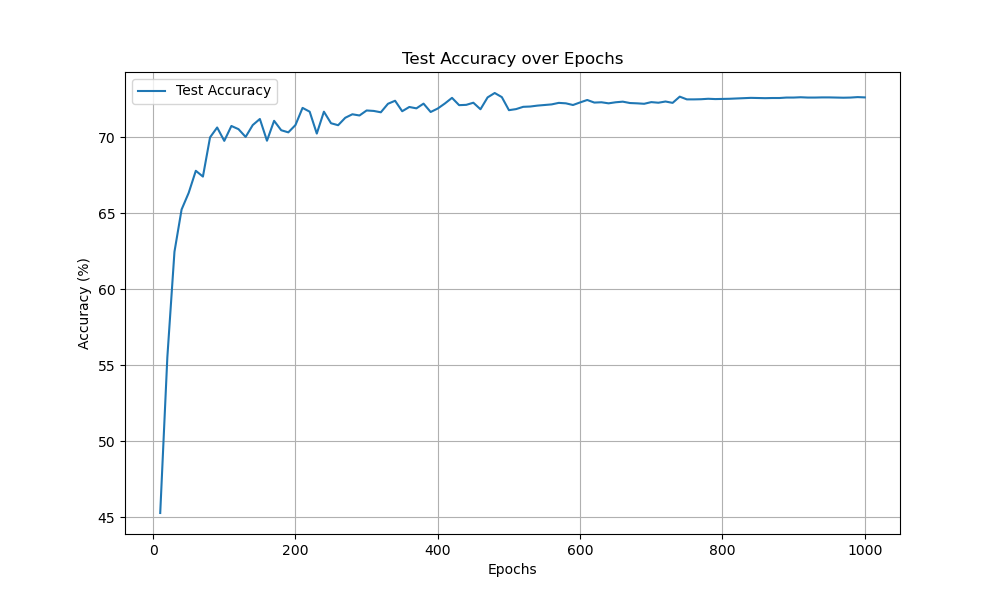

In [ ]:
with open("single_device_acc.txt", "w") as file:
    for value in device['test_acc_tracker']:
        file.write(f"{value}\n")

**Implementing Components for Federated Learning**
 Since the client only had a 10% subset of the full CIFAR-10 training set, it performed significantly worse than the same model trained on the entire training set.

Federated Learning aims to improve the performance of these client devices by averaging the updates from multiple clients over the course of training. This way, a centralized server is able to be updated using the training data stored on local devices without having access to the training data.
By using more client devices, you will be able to leverage the entire dataset.
In a way, this simulates traditional gradient descent, but with additional epochs performed on each client before averaging, where each epoch uses mini-batches of size 128.
An additional benefit of federated learning is that the centralized server does not require large compute resources, as most of the training computation is performed on local devices.
This makes the training computation "free" for the centralized server, as the clients pay the compute cost on their local devices.


In [ ]:
import copy


def average_weights(devices):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''

    num_devices = len(devices)
    if num_devices == 0:
        return None

    avg_weights = OrderedDict()

    for i, device in enumerate(devices):
        state_dict = device['net'].state_dict()
        if i == 0:
            for key in state_dict.keys():
                avg_weights[key] = state_dict[key].clone()
        else:
            for key in state_dict.keys():
                avg_weights[key] += state_dict[key]

    for key in avg_weights.keys():
        avg_weights[key] = avg_weights[key] / num_devices

    return avg_weights


def get_devices_for_round(devices, device_pct):
    '''
    '''
    num_devices = len(devices)
    num_selected = max(1, int(device_pct * num_devices))
    selected_devices = random.sample(devices, num_selected)
    return selected_devices

# Test code for average_weights
class TestNetwork(nn.Module):
    '''
    A simple 2 layer MLP used for testing your average_weights implementation.
    '''
    def __init__(self):
        super(TestNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 2)
        self.layer2 = nn.Linear(2, 4)

    def forward(self, x):
        h = F.relu(self.layer1(x))
        return self.layer2(h)

data_pct = 0.05
num_devices = 2
net = TestNetwork()
data_idxs = iid_sampler(trainset, num_devices, data_pct)
devices = [create_device(net, i, trainset, data_idxs[i])
           for i in range(num_devices)]

# Fixed seeding to compare against precomputed correct_weight_averages below
torch.manual_seed(0)
devices[0]['net'].layer1.weight.data.normal_()
devices[0]['net'].layer1.bias.data.normal_()
devices[0]['net'].layer2.weight.data.normal_()
devices[0]['net'].layer2.bias.data.normal_()
devices[1]['net'].layer1.weight.data.normal_()
devices[1]['net'].layer1.bias.data.normal_()
devices[1]['net'].layer2.weight.data.normal_()
devices[1]['net'].layer2.bias.data.normal_()

# Precomputed correct averages
correct_weight_averages = OrderedDict(
    [('layer1.weight', torch.tensor([[ 0.3245, -0.9013], [-0.9042,  1.0125]])),
     ('layer1.bias', torch.tensor([-0.0724, -0.3119])),
     ('layer2.weight', torch.tensor([[0.2976,  1.0509], [-1.0048, -0.5972],
                                     [-0.3088, -0.2682], [-0.1690, -0.1060]])),
     ('layer2.bias', torch.tensor([-0.4396,  0.3327, -1.3925,  0.3160]))
    ])

# Computed weight averages
computed_weight_averages = average_weights(devices)

mismatch_found = False
for correct, computed in zip(correct_weight_averages.items(),
                             computed_weight_averages.items()):
    if not torch.allclose(correct[1], computed[1], atol=1e-2):
        mismatch_found = True
        print('Mismatch in tensor:', correct[0])

if not mismatch_found:
    print('Implementation output matches!')

In [ ]:
rounds = 100 #
local_epochs = 4
num_devices = 50
device_pct = 0.1
data_pct = 0.1
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()

data_idxs = iid_sampler(trainset, num_devices, data_pct)

devices = [create_device(net, device_id=i, trainset=trainset, data_idxs=data_idxs[i])
           for i in range(num_devices)]

## IID Federated Learning
start_time = time.time()
for round_num in range(rounds):
    round_devices = get_devices_for_round(devices, device_pct)

    print('Round: ', round_num)
    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # test accuracy after aggregation
    test(round_num, devices[0])


total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

In [ ]:
plt.figure(figsize=(10, 6))
rounds_list = [i for i in range(rounds)]
plt.plot(rounds_list, devices[0]['test_acc_tracker'], label='Test Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('Global Model Test Accuracy over Rounds')
plt.legend()
plt.grid(True)
plt.show()

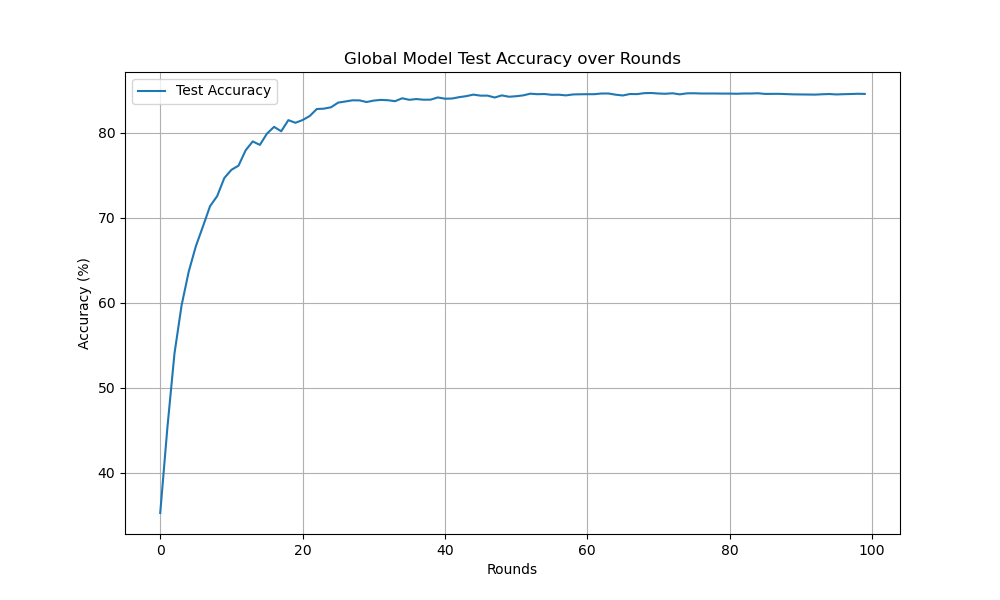

The accuracy is higher here, which makes sense because the global model benefits from having access to all the data across multiple devices. On the other hand, the local model was trained on only 10 percent of the data, resulting in lower accuracy.

In [ ]:
with open("multiple_device_acc.txt", "w") as file:
    for value in devices[0]['test_acc_tracker']:
        file.write(f"{value}\n")

---

### **2. Non-IID Federated Learning and Fairness**

---
**Overview**

Earlier, I implemented a Federated Learning pipeline that operated on IID data.
While this IID assumption may hold in some applications, it does not hold in many other settings.
For example, a group of similar users may have data that is fundamentally different from that of another group of users.
As a result, the aggregate data that federated learning operates on will be non-IID in nature.

Here I explored using Federated Learning in a non-IID setting and created groups of devices such that the inter-group data is non-IID and the intra-group data is IID.

In [ ]:
from collections import defaultdict
# creates noniid TRAINING datasets for each group
def noniid_group_sampler(dataset, num_items_per_device):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    num_items_per_device: how many samples to assign to each device

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    '''

    # how many devices per non-iid group
    devices_per_group = [20, 20, 20]

    # label assignment per group
    dict_group_classes = {}
    dict_group_classes[0] = [0,1,2,3]
    dict_group_classes[1] = [4,5,6]
    dict_group_classes[2] = [7,8,9]

    sampled = {}

    label_to_indices_map = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        label_to_indices_map[label].append(idx)

    group_indices = {}
    for group_id, class_labels in dict_group_classes.items():
        indices_in_group = []
        for class_label in class_labels:
            indices_in_group += label_to_indices_map[class_label]
        group_indices[group_id] = indices_in_group

    # now we assign the sample in each group to devices
    device_id = 0
    for group_id, num_devices in enumerate(devices_per_group):
        indices_in_group = group_indices[group_id]

        # assign samples to each device in the group
        for i in range(num_devices):
            sampled[device_id] = np.random.choice(
                indices_in_group, num_items_per_device, replace=True
            ).tolist()
            device_id += 1

    return sampled

---
**Group-based Device Rejection**


We will now implement `get_devices_for_round_GROUP`, a new group-based version of the `get_devices_for_round` to simulate the device rejection phase shown earlier on a per-group basis.  

In [ ]:
# get which devices in each group should participate in a current round
# by explicitly saying number of each devices desired for each group
def get_devices_for_round_GROUP(devices, device_nums, user_group_idxs):
    # Assume first 20 are group 0, second 20 are group 1, third 20 are group 2
    group_ranges = {
        0: range(0, 20),
        1: range(20, 40),
        2: range(40, 60)
    }

    selected_devices = []

    for group_id, num_devices_to_select in enumerate(device_nums):
        device_ids_in_group = list(group_ranges[group_id])
        selected_ids = random.sample(device_ids_in_group, num_devices_to_select)
        for device_id in selected_ids:
            selected_devices.append(devices[device_id])

    return selected_devices

In [ ]:
# creates noniid TEST datasets for each group
def cifar_noniid_group_test(dataset):

    dict_group_classes = {}
    dict_group_classes[0] = [0,1,2,3]
    dict_group_classes[1] = [4,5,6]
    dict_group_classes[2] = [7,8,9]

    test_samples = {0: [], 1: [], 2: []}

    for idx, (_, label) in enumerate(dataset):
        for group_id, class_labels in dict_group_classes.items():
            if label in class_labels:
                test_samples[group_id].append(idx)
                break

    test_samples = {k: set(v) for k, v in test_samples.items()}

    return test_samples

# gets per-group accuracy of global model
def test_group(epoch, device, group_idxs_dict):

    net = device['net']
    net.eval()
    criterion = nn.CrossEntropyLoss()
    group_accuracies = {}

    for group_id, idxs in group_idxs_dict.items():
        subset = torch.utils.data.Subset(testset, list(idxs))
        loader = torch.utils.data.DataLoader(subset, batch_size=128, shuffle=False)

        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.cuda(), targets.cuda()
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        acc = 100. * correct / total if total > 0 else 0
        group_accuracies[group_id] = acc
        print(f'Group {group_id} | Test Accuracy: {acc:.3f}%')

    return group_accuracies

---
**Federated Learning Results in Non-IID Setting**

We will now run federated learning in the non-IID setting using the functions previously wrote.
We will examine two different scenarios:

**Fair Device Participation:** we run federated learning on the CIFAR-10 dataset with three groups. Each group will have exactly one device participate in each round.

**Unfair Device Participation:** run federated learning on the CIFAR-10 dataset with three groups.
Group 0 will have five devices participate in each round, and Groups 1 and 2 will each only have one device participate in each round.

In [ ]:
group_acc_tracker = {0: [], 1: [], 2: []}

# Fair device participation scenario
rounds = 100
local_epochs = 1
num_items_per_device = 5000
device_nums = [1,1,1]
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()
milestones=[250, 500, 750]

data_idxs = noniid_group_sampler(trainset, num_items_per_device)

devices = []
for device_id in data_idxs.keys():
    if device_id < 20:
        group_id = 0
    elif device_id < 40:
        group_id = 1
    else:
        group_id = 2
    device = create_device(net, device_id, trainset, data_idxs[device_id], milestones=milestones, lr=0.001)
    devices.append(device)

test_idxs = cifar_noniid_group_test(testset)
## Non-IID Federated Learning
start_time = time.time()
for round_num in range(rounds):

    # Get devices for each round
    round_devices = get_devices_for_round_GROUP(devices, device_nums, None)

    print('Round: ', round_num)
    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # Test accuracy
    group_accuracies = test_group(round_num, device, test_idxs)

    for group_id in group_acc_tracker.keys():
        group_acc_tracker[group_id].append(group_accuracies[group_id])

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

In [ ]:
plt.figure(figsize=(10, 6))
rounds_list = list(range(1, rounds + 1))
for group_id in group_acc_tracker.keys():
    plt.plot(rounds_list, group_acc_tracker[group_id], label=f'Group {group_id}')
plt.xlabel('Rounds')
plt.ylabel('Test Accuracy (%)')
plt.title('Per-Group Test Accuracy over Rounds (Fair Participation)')
plt.legend()
plt.grid(True)
plt.show()

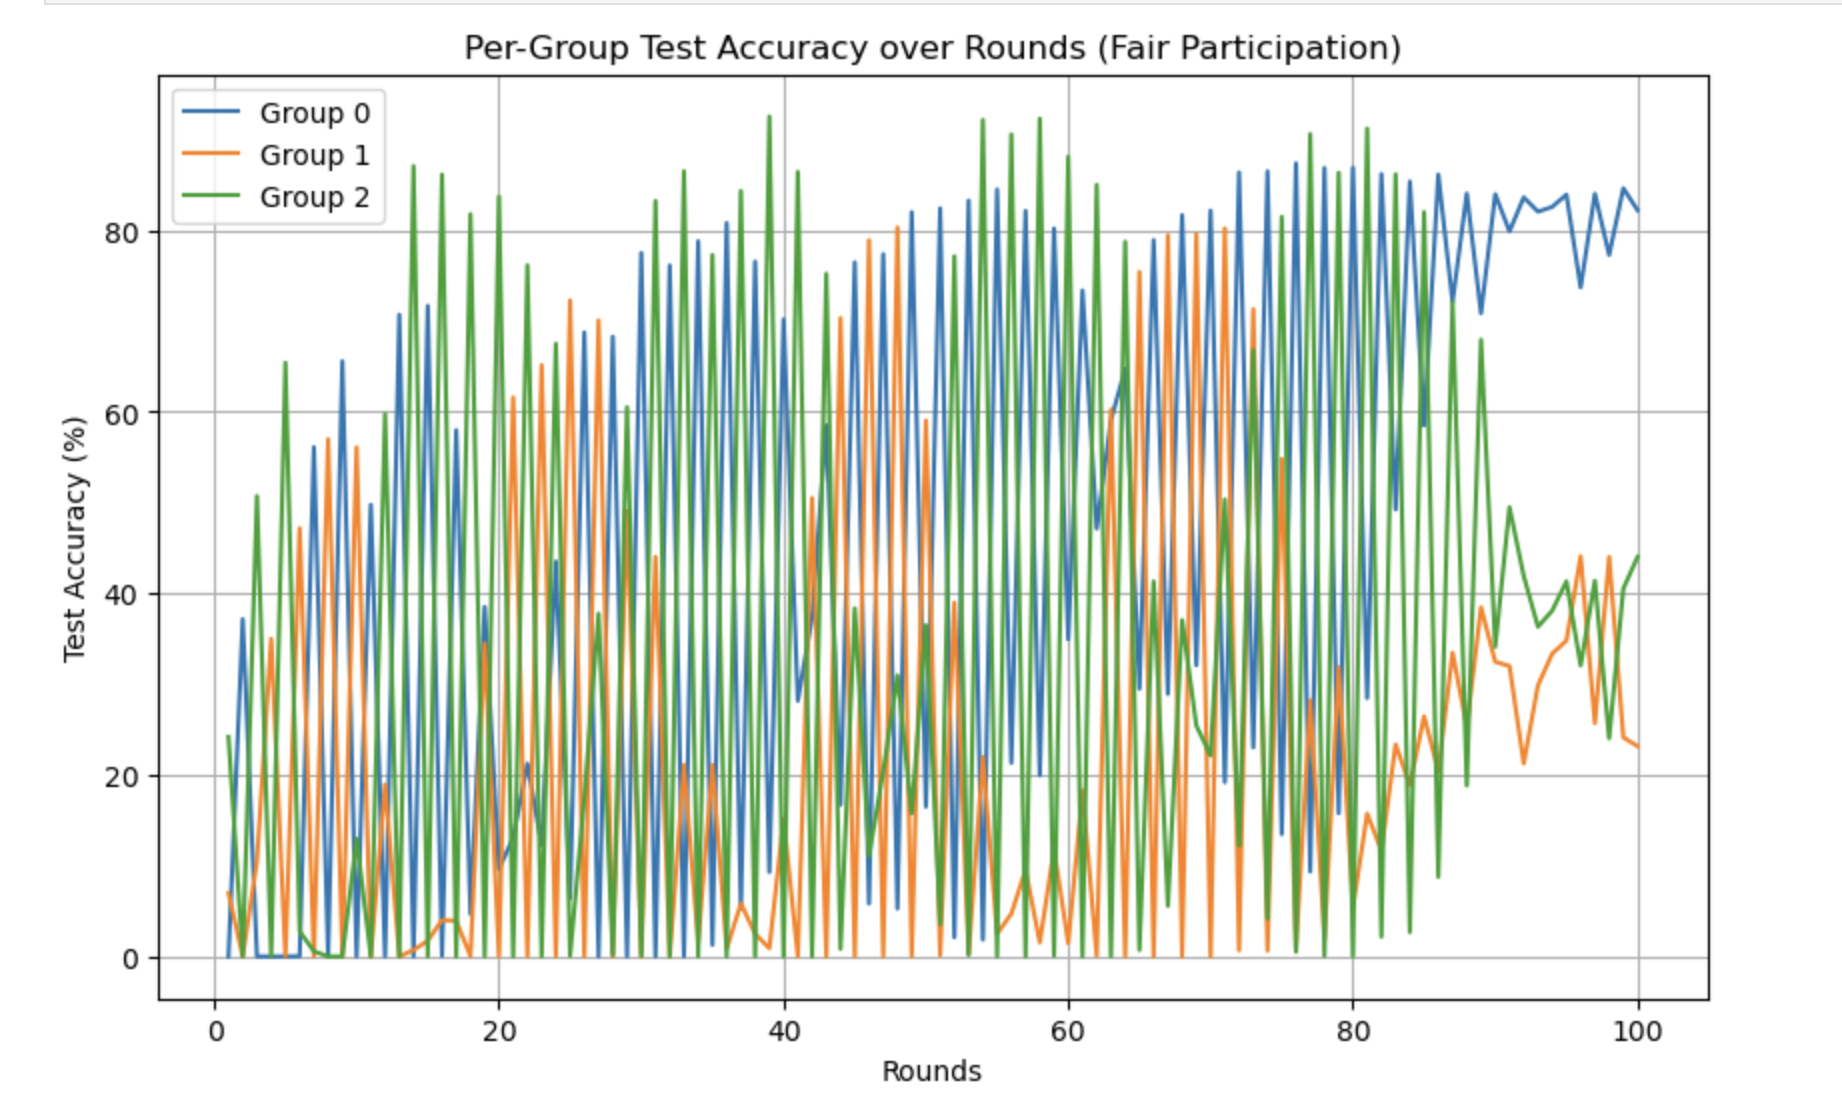

In [ ]:
with open("fair_group_acc.csv", "w") as file:
    file.write('group_1, group_2, group_3\n')
    for i in range(len(group_acc_tracker[0])):
        file.write(f"{group_acc_tracker[0][i]},{group_acc_tracker[0][i]},{group_acc_tracker[0][i]}\n")

In [ ]:
group_acc_tracker = {0: [], 1: [], 2: []}

# Unfair device partricipation scenario
rounds = 100
local_epochs = 1
num_items_per_device = 5000
device_nums = [5, 1, 1]
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()
milestones=[250, 500, 750]

data_idxs = noniid_group_sampler(trainset, num_items_per_device)

devices = []
for device_id in data_idxs.keys():
    if device_id < 20:
        group_id = 0
    elif device_id < 40:
        group_id = 1
    else:
        group_id = 2
    device = create_device(net, device_id, trainset, data_idxs[device_id], milestones=milestones)
    devices.append(device)

test_idxs = cifar_noniid_group_test(testset)
## Non-IID Federated Learning
start_time = time.time()
for round_num in range(rounds):

    # Get devices for each round
    round_devices = get_devices_for_round_GROUP(devices, device_nums, None)

    print('Round: ', round_num)
    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # Test accuracy
    group_accuracies = test_group(round_num, device, test_idxs)

    for group_id in group_acc_tracker.keys():
        group_acc_tracker[group_id].append(group_accuracies[group_id])

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

In [ ]:
plt.figure(figsize=(10, 6))
rounds_list = list(range(1, rounds + 1))
for group_id in group_acc_tracker.keys():
    plt.plot(rounds_list, group_acc_tracker[group_id], label=f'Group {group_id}')
plt.xlabel('Rounds')
plt.ylabel('Test Accuracy (%)')
plt.title('Per-Group Test Accuracy over Rounds (Unfair Participation)')
plt.legend()
plt.grid(True)
plt.show()

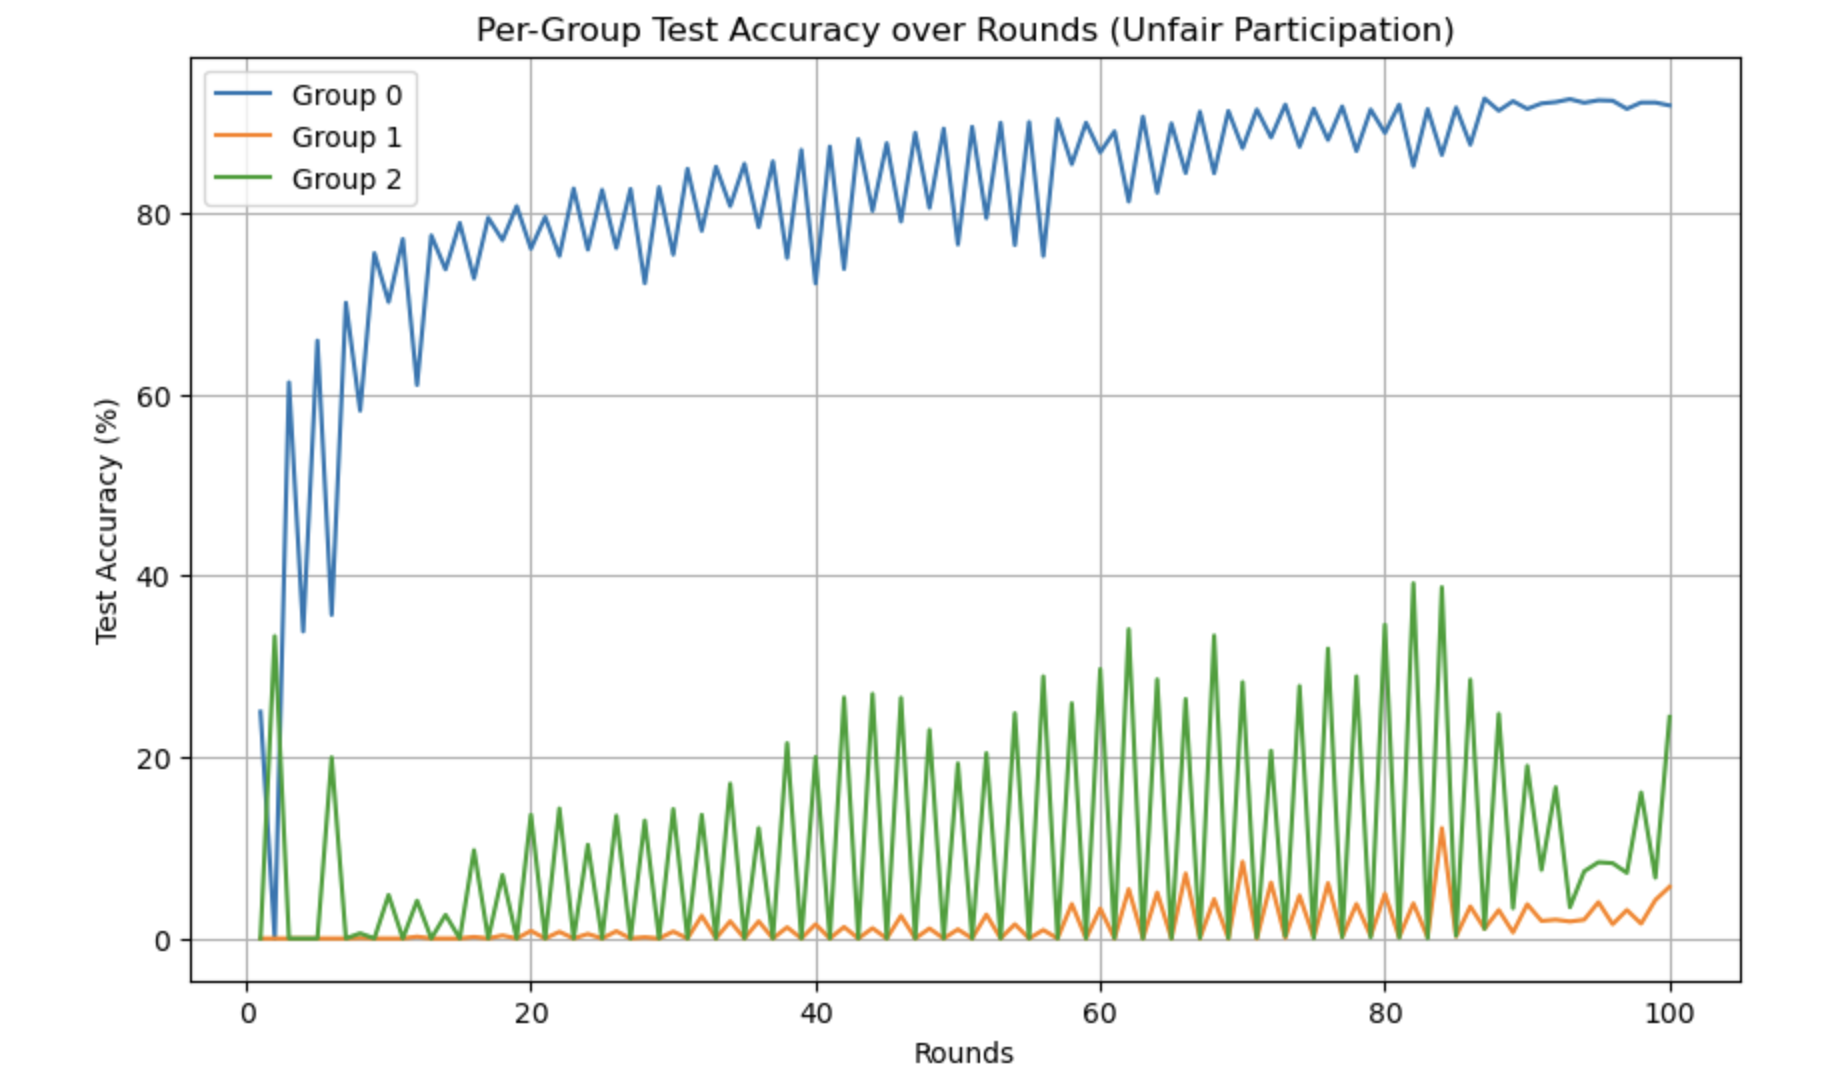

In [ ]:
with open("unfair_group_acc.csv", "w") as file:
    file.write('group_1, group_2, group_3\n')
    for i in range(len(group_acc_tracker[0])):
        file.write(f"{group_acc_tracker[0][i]},{group_acc_tracker[0][i]},{group_acc_tracker[0][i]}\n")

The most noticeable trend is that the samples in Group 0 perform significantly better than those in the other groups in the unfair device participation scenario. This is expected because Group 0's samples are overrepresented—appearing five times more frequently than those in the other groups—resulting in a higher accuracy for Group 0. Another interesting observation is the fluctuation in accuracy across rounds. For example, in the fair device device participation scenario, the accuracy for group zero can be 80 percent in one round and near 0 in another. It appears that one group tends to make more significant updates to the model weights, temporarily boosting its accuracy, and then this progress is lost in other rounds where changes from other groups are more significant.